In [421]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import time, os
from random import randint

import lxml


In [422]:
def Get_Top_BoxOffice(url):
    """
    Converts BoxOfficeMojo table into pandas DFs.
    In: url link  for "Top Lifetime Grosses (Worldwide)"
    Out: dataframe of table
    """
    
    response = requests.get(url)
    page = response.text   
    soup = BeautifulSoup(page)
    table = soup.find(id='table')  
    
    rows = [row for row in table.find_all('tr')]
    movies = {} 
    for row in rows[1:]:
        items = row.find_all('td')
        link = items[1].find('a')
        title, url_string = link.text, link['href']
        #split url info into unique movie serial number
        url = url_string.split('?', 1)[0].split('t', 4)[-1].split('/', 1)[0]
        #set serial number as key avoiding duplication in any other category
        movies[url] = [url_string] +[i.text for i in items]    
    movie_info = pd.DataFrame(movies).T  #transpose
    movie_info.columns = ['URL', 'Rank', 'Title', 'World_Gross', 
                    'Domestic_Gross', 'Domestic_Percentage', 'Foreign_Gross', 'Foreign_Percentage','Year']

    return movie_info

In [423]:
def mojo_movie_dict(url_id):
    '''
    From BoxOfficeMojo link stub, request movie html, parse with BeautifulSoup, and
    collect 
        - Title 
        - Domestic opening gross
        - Rating (MPAA) 
        - Foreign market count
        - Genres
        - Distributor
        - Budget
        
    Return information as a dictionary.
    '''
    
    main_url = 'https://www.boxofficemojo.com/title/tt'    
    url = main_url + url_id
        
    #Request HTML , parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['id', 'mojo_title', 'domestic_opening_gross',
                'rating', 'foreign_market_count', 'genres', 'distributor', 'budget'
                ]
    
    #title
    title_string = soup.find(class_= 'a-size-extra-large').text
    mojo_title = title_string.split('(')[0].strip()

    #distribution company
    distributor= soup.find(class_='a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile').find_all('span')[1].contents[0] 

    #domestic opening
    try:
        domestic_opening = soup.find(text='Domestic Opening').findNext().find(class_= 'money').text
    except:
        domestic_opening = np.nan

    #rating
    try:
        rating = soup.find(text='MPAA').findNext().text

    except:
        rating = np.nan 

    #foreign markets
    try: 
        if soup.find(text = 'Markets'):
            foreign_markets = soup.find('table', class_= 'a-bordered a-horizontal-stripes a-size-base-plus').find_all(class_='a-link-normal')[1].text[0:2]
        else:
            market_links = soup.find(class_='a-section mojo-h-scroll').find_all(class_= 'a-link-normal')
            foreign_markets = len(market_links)-1
    except:
        foreign_markets = np.nan

    #genres
    try:
        genres = soup.find(text='Genres').findNext().text
    except:
        genres = np.nan
        
    #budget
    try:
        budget = soup.find(text='Budget').findNext().text
    except:
        budget = np.nan


    #create url to scrape credits page
    credits_url = url+'/credits'

    #Request HTML and parse
    response = requests.get(credits_url)
    page = response.text
    credits_soup = BeautifulSoup(page,"lxml")



    #Create movie dictionary and return
    mojo_dict = dict(zip(headers, [url_id, 
                                mojo_title,
                                domestic_opening,
                                rating, 
                                foreign_markets,
                                genres,
                                distributor,
                                budget]))


    return mojo_dict

In [424]:
df_movie = Get_Top_BoxOffice('https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/')

In [425]:
df_movie.head()

,URL,Rank,Title,World_Gross,Domestic_Gross,Domestic_Percentage,Foreign_Gross,Foreign_Percentage,Year
4154796,/title/tt4154796/?ref_=bo_cso_table_1,1,Avengers: Endgame,"$2,797,800,564","$858,373,000",30.7%,"$1,939,427,564",69.3%,2019
0499549,/title/tt0499549/?ref_=bo_cso_table_2,2,Avatar,"$2,790,439,092","$760,507,625",27.2%,"$2,029,931,467",72.8%,2009
0120338,/title/tt0120338/?ref_=bo_cso_table_3,3,Titanic,"$2,471,754,307","$659,363,944",26.7%,"$1,812,390,363",73.3%,1997
2488496,/title/tt2488496/?ref_=bo_cso_table_4,4,Star Wars: Episode VII - The Force Awakens,"$2,068,454,310","$936,662,225",45.3%,"$1,131,792,085",54.7%,2015
4154756,/title/tt4154756/?ref_=bo_cso_table_5,5,Avengers: Infinity War,"$2,048,359,754","$678,815,482",33.1%,"$1,369,544,272",66.9%,2018


In [426]:
#turn index into list
links = df_movie.index.tolist()

In [427]:
print(links[0])
print(mojo_movie_dict(links[0]))

4154796
{'id': '4154796', 'mojo_title': 'Avengers: Endgame', 'domestic_opening_gross': '$357,115,007', 'rating': 'PG-13', 'foreign_market_count': 56, 'genres': 'Action\n    \n        Adventure\n    \n        Drama\n    \n        Sci-Fi', 'distributor': 'Walt Disney Studios Motion Pictures', 'budget': '$356,000,000'}


In [428]:
first_200 = links[0:200]

In [429]:
mojo_dict_list = []

In [430]:
#feeding link lists to function taking  partial list and scraping each url
#returning dictionary of values for  movie url page and appending into existing list.
for link in first_200:
    mojo_dict_list.append(mojo_movie_dict(link))
    
    #random sleep counter 1-4 seconds to avoid being blocked while scraping
    time.sleep(randint(4,6))

In [431]:
#turn list of dictionaries into dataframe. 
mojo_df = pd.DataFrame(mojo_dict_list)  #convert list of dict to df
mojo_df.set_index('id', inplace=True)

mojo_df.shape
mojo_df.head(200)

,mojo_title,domestic_opening_gross,rating,foreign_market_count,genres,distributor,budget
id,,,,,,,
4154796,Avengers: Endgame,"$357,115,007",PG-13,56,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$356,000,000"
0499549,Avatar,"$77,025,481",PG-13,77,Action\n \n Adventure\n \n ...,Twentieth Century Fox,"$237,000,000"
0120338,Titanic,"$28,638,131",PG-13,Do,Drama\n \n Romance,Paramount Pictures,"$200,000,000"
2488496,Star Wars: Episode VII - The Force Awakens,"$247,966,675",PG-13,62,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$245,000,000"
4154756,Avengers: Infinity War,"$257,698,183",PG-13,54,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,NaN
...,...,...,...,...,...,...,...
0462538,The Simpsons Movie,"$74,036,787",PG-13,73,Adventure\n \n Animation\n \n ...,Twentieth Century Fox,"$75,000,000"
1663202,The Revenant,"$474,560",R,63,Action\n \n Adventure\n \n ...,Twentieth Century Fox,"$135,000,000"
4779682,The Meg,"$45,402,195",PG-13,41,Action\n \n Horror\n \n Sc...,Warner Bros.,"$130,000,000"


In [432]:
mojo_dict_list

[{'id': '4154796',
  'mojo_title': 'Avengers: Endgame',
  'domestic_opening_gross': '$357,115,007',
  'rating': 'PG-13',
  'foreign_market_count': 56,
  'genres': 'Action\n    \n        Adventure\n    \n        Drama\n    \n        Sci-Fi',
  'distributor': 'Walt Disney Studios Motion Pictures',
  'budget': '$356,000,000'},
 {'id': '0499549',
  'mojo_title': 'Avatar',
  'domestic_opening_gross': '$77,025,481',
  'rating': 'PG-13',
  'foreign_market_count': '77',
  'genres': 'Action\n    \n        Adventure\n    \n        Fantasy\n    \n        Sci-Fi',
  'distributor': 'Twentieth Century Fox',
  'budget': '$237,000,000'},
 {'id': '0120338',
  'mojo_title': 'Titanic',
  'domestic_opening_gross': '$28,638,131',
  'rating': 'PG-13',
  'foreign_market_count': 'Do',
  'genres': 'Drama\n    \n        Romance',
  'distributor': 'Paramount Pictures',
  'budget': '$200,000,000'},
 {'id': '2488496',
  'mojo_title': 'Star Wars: Episode VII - The Force Awakens',
  'domestic_opening_gross': '$247,9

In [433]:
#mojo_df.to_csv("my_mojo.csv", index = False, header = True)

In [434]:
mojo_df['domestic_opening_gross_clean'] = mojo_df['domestic_opening_gross'].replace('[$ ,]', '', regex=True)

In [435]:
mojo_df['budget_clean'] = mojo_df['budget'].replace('[$ ,]', '', regex=True).dropna(axis = 0)

In [436]:
mojo_df.head()

,mojo_title,domestic_opening_gross,rating,foreign_market_count,genres,distributor,budget,domestic_opening_gross_clean,budget_clean
id,,,,,,,,,
4154796,Avengers: Endgame,"$357,115,007",PG-13,56,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$356,000,000",357115007,356000000
0499549,Avatar,"$77,025,481",PG-13,77,Action\n \n Adventure\n \n ...,Twentieth Century Fox,"$237,000,000",77025481,237000000
0120338,Titanic,"$28,638,131",PG-13,Do,Drama\n \n Romance,Paramount Pictures,"$200,000,000",28638131,200000000
2488496,Star Wars: Episode VII - The Force Awakens,"$247,966,675",PG-13,62,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$245,000,000",247966675,245000000
4154756,Avengers: Infinity War,"$257,698,183",PG-13,54,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,NaN,257698183,NaN


In [437]:
mojo_df['foreign_market_count_clean'] = mojo_df['foreign_market_count'].replace('[A-z]', '', regex=True)

mojo_df0 = mojo_df[mojo_df['foreign_market_count_clean'] != '']
mojo_df1 = mojo_df0.dropna(axis = 0)
mojo_df1.head()

,mojo_title,domestic_opening_gross,rating,foreign_market_count,genres,distributor,budget,domestic_opening_gross_clean,budget_clean,foreign_market_count_clean
id,,,,,,,,,,
4154796,Avengers: Endgame,"$357,115,007",PG-13,56,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$356,000,000",357115007,356000000,56
0499549,Avatar,"$77,025,481",PG-13,77,Action\n \n Adventure\n \n ...,Twentieth Century Fox,"$237,000,000",77025481,237000000,77
2488496,Star Wars: Episode VII - The Force Awakens,"$247,966,675",PG-13,62,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$245,000,000",247966675,245000000,62
0369610,Jurassic World,"$208,806,270",PG-13,66,Action\n \n Adventure\n \n ...,Universal Pictures,"$150,000,000",208806270,150000000,66
6105098,The Lion King,"$191,770,759",PG,56,Adventure\n \n Animation\n \n ...,Walt Disney Studios Motion Pictures,"$260,000,000",191770759,260000000,56


In [438]:
from sklearn import linear_model

In [439]:
lr = linear_model.LinearRegression()

X = mojo_df1[['foreign_market_count_clean']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)


print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))


mojo_df1['foreign_market_count_clean'] = mojo_df1['foreign_market_count_clean'].astype(float)


mojo_df1['domestic_opening_gross_model'] = predicted.intercept_ + mojo_df1['foreign_market_count_clean']*predicted.coef_[0]

mojo_df1.head(20)

[331911.77331058]
70989540.41593108
0.010365636747042162


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mojo_title,domestic_opening_gross,rating,foreign_market_count,genres,distributor,budget,domestic_opening_gross_clean,budget_clean,foreign_market_count_clean,domestic_opening_gross_model
id,,,,,,,,,,,
4154796,Avengers: Endgame,"$357,115,007",PG-13,56,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$356,000,000",357115007,356000000,56.0,8.957660e+07
0499549,Avatar,"$77,025,481",PG-13,77,Action\n \n Adventure\n \n ...,Twentieth Century Fox,"$237,000,000",77025481,237000000,77.0,9.654675e+07
2488496,Star Wars: Episode VII - The Force Awakens,"$247,966,675",PG-13,62,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$245,000,000",247966675,245000000,62.0,9.156807e+07
0369610,Jurassic World,"$208,806,270",PG-13,66,Action\n \n Adventure\n \n ...,Universal Pictures,"$150,000,000",208806270,150000000,66.0,9.289572e+07
6105098,The Lion King,"$191,770,759",PG,56,Adventure\n \n Animation\n \n ...,Walt Disney Studios Motion Pictures,"$260,000,000",191770759,260000000,56.0,8.957660e+07
0848228,The Avengers,"$207,438,708",PG-13,60,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$220,000,000",207438708,220000000,60.0,9.090425e+07
2820852,Furious 7,"$147,187,040",PG-13,68,Action\n \n Adventure\n \n ...,Universal Pictures,"$190,000,000",147187040,190000000,68.0,9.355954e+07
4520988,Frozen II,"$130,263,358",PG,53,Adventure\n \n Animation\n \n ...,Walt Disney Studios Motion Pictures,"$150,000,000",130263358,150000000,53.0,8.858086e+07
2395427,Avengers: Age of Ultron,"$191,271,109",PG-13,66,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$250,000,000",191271109,250000000,66.0,9.289572e+07


In [440]:
lr = linear_model.LinearRegression()

X = mojo_df1[['budget_clean']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

#mojo_df1['foreign_market_count_clean'] = pd.to_numeric(mojo_df1['foreign_market_count_clean'])
mojo_df1['budget_clean'] = mojo_df1['budget_clean'].astype(float)

#df['MyColumnName'] = df['MyColumnName'].astype('float64')
mojo_df1['domestic_opening_gross_model'] = predicted.intercept_ + mojo_df1['budget_clean']*predicted.coef_[0]
#mojo_df1.head()

#mojo_df1['domestic_opening_gross_model']

mojo_df1.head(20)

[0.37657563]
32198175.33067804
0.21585720883822868


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mojo_title,domestic_opening_gross,rating,foreign_market_count,genres,distributor,budget,domestic_opening_gross_clean,budget_clean,foreign_market_count_clean,domestic_opening_gross_model
id,,,,,,,,,,,
4154796,Avengers: Endgame,"$357,115,007",PG-13,56,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$356,000,000",357115007,356000000.0,56.0,1.662591e+08
0499549,Avatar,"$77,025,481",PG-13,77,Action\n \n Adventure\n \n ...,Twentieth Century Fox,"$237,000,000",77025481,237000000.0,77.0,1.214466e+08
2488496,Star Wars: Episode VII - The Force Awakens,"$247,966,675",PG-13,62,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$245,000,000",247966675,245000000.0,62.0,1.244592e+08
0369610,Jurassic World,"$208,806,270",PG-13,66,Action\n \n Adventure\n \n ...,Universal Pictures,"$150,000,000",208806270,150000000.0,66.0,8.868452e+07
6105098,The Lion King,"$191,770,759",PG,56,Adventure\n \n Animation\n \n ...,Walt Disney Studios Motion Pictures,"$260,000,000",191770759,260000000.0,56.0,1.301078e+08
0848228,The Avengers,"$207,438,708",PG-13,60,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$220,000,000",207438708,220000000.0,60.0,1.150448e+08
2820852,Furious 7,"$147,187,040",PG-13,68,Action\n \n Adventure\n \n ...,Universal Pictures,"$190,000,000",147187040,190000000.0,68.0,1.037475e+08
4520988,Frozen II,"$130,263,358",PG,53,Adventure\n \n Animation\n \n ...,Walt Disney Studios Motion Pictures,"$150,000,000",130263358,150000000.0,53.0,8.868452e+07
2395427,Avengers: Age of Ultron,"$191,271,109",PG-13,66,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$250,000,000",191271109,250000000.0,66.0,1.263421e+08


In [441]:
mojo_df1['dummy_for_action'] = mojo_df1.genres.apply(lambda x : 1 if 'Action' in x else 0)
mojo_df1['dummy_for_adventure'] = mojo_df1.genres.apply(lambda x : 1 if 'Adventure' in x else 0)
mojo_df1['dummy_for_animation'] = mojo_df1.genres.apply(lambda x : 1 if 'Animation' in x else 0)
mojo_df1['dummy_for_comedy'] = mojo_df1.genres.apply(lambda x : 1 if 'Comedy' in x else 0)
mojo_df1['dummy_for_crime'] = mojo_df1.genres.apply(lambda x : 1 if 'Crime' in x else 0)
mojo_df1['dummy_for_drama'] = mojo_df1.genres.apply(lambda x : 1 if 'Drama' in x else 0)
mojo_df1['dummy_for_family'] = mojo_df1.genres.apply(lambda x : 1 if 'Family' in x else 0)
mojo_df1['dummy_for_fantasy'] = mojo_df1.genres.apply(lambda x : 1 if 'Fantasy' in x else 0)
mojo_df1['dummy_for_mystery'] = mojo_df1.genres.apply(lambda x : 1 if 'Mystery' in x else 0)
mojo_df1['dummy_for_thriller'] = mojo_df1.genres.apply(lambda x : 1 if 'Thriller' in x else 0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [442]:
mojo_df1.head()

,mojo_title,domestic_opening_gross,rating,foreign_market_count,genres,distributor,budget,domestic_opening_gross_clean,budget_clean,foreign_market_count_clean,...,dummy_for_action,dummy_for_adventure,dummy_for_animation,dummy_for_comedy,dummy_for_crime,dummy_for_drama,dummy_for_family,dummy_for_fantasy,dummy_for_mystery,dummy_for_thriller
id,,,,,,,,,,,,,,,,,,,,,
4154796,Avengers: Endgame,"$357,115,007",PG-13,56,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$356,000,000",357115007,356000000.0,56.0,...,1,1,0,0,0,1,0,0,0,0
0499549,Avatar,"$77,025,481",PG-13,77,Action\n \n Adventure\n \n ...,Twentieth Century Fox,"$237,000,000",77025481,237000000.0,77.0,...,1,1,0,0,0,0,0,1,0,0
2488496,Star Wars: Episode VII - The Force Awakens,"$247,966,675",PG-13,62,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$245,000,000",247966675,245000000.0,62.0,...,1,1,0,0,0,0,0,0,0,0
0369610,Jurassic World,"$208,806,270",PG-13,66,Action\n \n Adventure\n \n ...,Universal Pictures,"$150,000,000",208806270,150000000.0,66.0,...,1,1,0,0,0,0,0,0,0,0
6105098,The Lion King,"$191,770,759",PG,56,Adventure\n \n Animation\n \n ...,Walt Disney Studios Motion Pictures,"$260,000,000",191770759,260000000.0,56.0,...,0,1,1,0,0,1,1,0,0,0


In [443]:
X = mojo_df1[['dummy_for_action']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[20067750.34445864]
77353753.33870967
0.038695354038751684


In [444]:
X = mojo_df1[['dummy_for_adventure']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[17625361.68633142]
74541893.13636363
0.014786529409370641


In [445]:
X = mojo_df1[['dummy_for_animation']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[-28130245.13867018]
96001186.52755906
0.05551388707168925


In [446]:
X = mojo_df1[['dummy_for_comedy']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[-24542450.59786823]
96262760.45833333
0.04769072611539937


In [447]:
X = mojo_df1[['dummy_for_crime']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[7057017.53290872]
89528604.13375796
0.0007198494512531406


In [448]:
X = mojo_df1[['dummy_for_drama']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[-7094714.46456503]
91137673.17424242
0.003160485849462824


In [449]:
X = mojo_df1[['dummy_for_family']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[-22072404.32300887]
96559047.82300885
0.04223729685770006


In [450]:
X = mojo_df1[['dummy_for_fantasy']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[-12477351.6600619]
94993647.18947367
0.015432124948783543


In [451]:
X = mojo_df1[['dummy_for_mystery']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[-8527982.7525252]
90259241.86363636
0.001546693424620993


In [452]:
X = mojo_df1[['dummy_for_thriller']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[-8059872.11212121]
91420124.89999999
0.004276239059514353


In [453]:
mojo_df1['dummy_for_rating_G'] = mojo_df1.rating.apply(lambda x : 1 if x =='G'  else 0)
mojo_df1['dummy_for_rating_PG'] = mojo_df1.rating.apply(lambda x : 1 if x =='PG'  else 0)
mojo_df1['dummy_for_rating_PG13'] = mojo_df1.rating.apply(lambda x : 1 if x =='PG-13'  else 0)

#X = mojo_df1[['dummy_for_rating_G']]
#X = mojo_df1[['dummy_for_rating_PG']]
X = mojo_df1[['dummy_for_rating_PG13']]

y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[24268371.85707442]
74750914.24193548
0.056590395263775184


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [454]:
X = mojo_df1[['foreign_market_count_clean', 'dummy_for_action', 'dummy_for_adventure', 'dummy_for_animation', \
              'dummy_for_comedy', 'dummy_for_crime', 'dummy_for_drama', 'dummy_for_family', \
              'dummy_for_fantasy', 'dummy_for_mystery', 'dummy_for_thriller']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[   433351.24200513  -8185924.58457669  20728634.13669604
 -15735647.11466595 -22270205.81205265  30537898.46494675
 -10980367.84430062 -10139782.22262955 -10780478.59709187
   1134977.82230177 -26343034.48945542]
75578405.1195808
0.143981975537133


In [455]:
mojo_df1.head()

,mojo_title,domestic_opening_gross,rating,foreign_market_count,genres,distributor,budget,domestic_opening_gross_clean,budget_clean,foreign_market_count_clean,...,dummy_for_comedy,dummy_for_crime,dummy_for_drama,dummy_for_family,dummy_for_fantasy,dummy_for_mystery,dummy_for_thriller,dummy_for_rating_G,dummy_for_rating_PG,dummy_for_rating_PG13
id,,,,,,,,,,,,,,,,,,,,,
4154796,Avengers: Endgame,"$357,115,007",PG-13,56,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$356,000,000",357115007,356000000.0,56.0,...,0,0,1,0,0,0,0,0,0,1
0499549,Avatar,"$77,025,481",PG-13,77,Action\n \n Adventure\n \n ...,Twentieth Century Fox,"$237,000,000",77025481,237000000.0,77.0,...,0,0,0,0,1,0,0,0,0,1
2488496,Star Wars: Episode VII - The Force Awakens,"$247,966,675",PG-13,62,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$245,000,000",247966675,245000000.0,62.0,...,0,0,0,0,0,0,0,0,0,1
0369610,Jurassic World,"$208,806,270",PG-13,66,Action\n \n Adventure\n \n ...,Universal Pictures,"$150,000,000",208806270,150000000.0,66.0,...,0,0,0,0,0,0,0,0,0,1
6105098,The Lion King,"$191,770,759",PG,56,Adventure\n \n Animation\n \n ...,Walt Disney Studios Motion Pictures,"$260,000,000",191770759,260000000.0,56.0,...,0,0,1,1,0,0,0,0,1,0


In [456]:
mojo_df1['dummy_for_disney'] = mojo_df1.distributor.apply(lambda x : 1 if 'Disney' in x else 0)
mojo_df1['dummy_for_sony'] = mojo_df1.distributor.apply(lambda x : 1 if 'Sony' in x else 0)
mojo_df1['dummy_for_twentieth'] = mojo_df1.distributor.apply(lambda x : 1 if 'Twentieth' in x else 0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [457]:
X = mojo_df1[['dummy_for_disney']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)
#predicted = lr.fit(X=mojo_df1[['foreign_market_count_clean']], y=mojo_df1['domestic_opening_gross_clean'])

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[29564150.25897633]
81807864.83193277
0.07022290992368474


In [458]:
X = mojo_df1[['foreign_market_count_clean',  'dummy_for_adventure','dummy_for_comedy', 'dummy_for_action', \
              'dummy_for_disney']]
y = mojo_df1['domestic_opening_gross_clean']
predicted = lr.fit(X, y)

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[   686091.30112357   7223638.04252278 -27484244.17362514
   8766124.29765048  37160966.81092638]
36468332.07824459
0.18606463174239707


In [459]:
mojo_df1['domestic_opening_gross_prediction'] = predicted.intercept_ + \
    mojo_df1['foreign_market_count_clean'].astype(float)*predicted.coef_[0] + \
    mojo_df1['dummy_for_adventure'].astype(float)*predicted.coef_[1] + \
    mojo_df1['dummy_for_comedy'].astype(float)*predicted.coef_[2] + \
    mojo_df1['dummy_for_action'].astype(float)*predicted.coef_[3] + \
    mojo_df1['dummy_for_disney'].astype(float)*predicted.coef_[4] 
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [460]:
mojo_df.head()

,mojo_title,domestic_opening_gross,rating,foreign_market_count,genres,distributor,budget,domestic_opening_gross_clean,budget_clean,foreign_market_count_clean
id,,,,,,,,,,
4154796,Avengers: Endgame,"$357,115,007",PG-13,56,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$356,000,000",357115007,356000000,56
0499549,Avatar,"$77,025,481",PG-13,77,Action\n \n Adventure\n \n ...,Twentieth Century Fox,"$237,000,000",77025481,237000000,77
0120338,Titanic,"$28,638,131",PG-13,Do,Drama\n \n Romance,Paramount Pictures,"$200,000,000",28638131,200000000,
2488496,Star Wars: Episode VII - The Force Awakens,"$247,966,675",PG-13,62,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,"$245,000,000",247966675,245000000,62
4154756,Avengers: Infinity War,"$257,698,183",PG-13,54,Action\n \n Adventure\n \n ...,Walt Disney Studios Motion Pictures,NaN,257698183,NaN,54


In [461]:
X = mojo_df1[['foreign_market_count_clean', 'budget_clean','dummy_for_action', 'dummy_for_adventure', 'dummy_for_animation', \
              'dummy_for_comedy', 'dummy_for_crime', 'dummy_for_drama', 'dummy_for_family', \
              'dummy_for_fantasy', 'dummy_for_mystery', 'dummy_for_thriller', 'dummy_for_disney', 
               'dummy_for_rating_G','dummy_for_rating_PG','dummy_for_rating_PG13' ]]
y = mojo_df1['domestic_opening_gross_clean'].astype(float)
predicted = lr.fit(X, y)

print(predicted.coef_)

print(predicted.intercept_)

predicted.fit(X, y)
print(predicted.score(X, y))

[ 4.02280112e+05  2.87466173e-01 -2.04866477e+07  1.36189259e+07
 -1.95678453e+06 -1.43075851e+07  3.35991342e+07 -5.10950923e+06
 -2.24024142e+07 -1.04081788e+07  1.69150478e+07 -1.69593898e+07
  2.86220885e+07 -5.01058960e+07 -2.45344729e+07 -1.87676782e+07]
53672513.89804984
0.3327499443153277


In [462]:
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

In [463]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [464]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 1951265 to 0848228
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   foreign_market_count_clean  97 non-null     float64
 1   budget_clean                97 non-null     float64
 2   dummy_for_action            97 non-null     int64  
 3   dummy_for_adventure         97 non-null     int64  
 4   dummy_for_animation         97 non-null     int64  
 5   dummy_for_comedy            97 non-null     int64  
 6   dummy_for_crime             97 non-null     int64  
 7   dummy_for_drama             97 non-null     int64  
 8   dummy_for_family            97 non-null     int64  
 9   dummy_for_fantasy           97 non-null     int64  
 10  dummy_for_mystery           97 non-null     int64  
 11  dummy_for_thriller          97 non-null     int64  
 12  dummy_for_disney            97 non-null     int64  
 13  dummy_for_rating_G          97 

In [465]:
lasso_model = Lasso(alpha = 1000000) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X_train.loc[:,:], y_train)

Lasso(alpha=1000000)

In [466]:
test_set_pred = lasso_model.predict(X_test.loc[:,:])

In [467]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

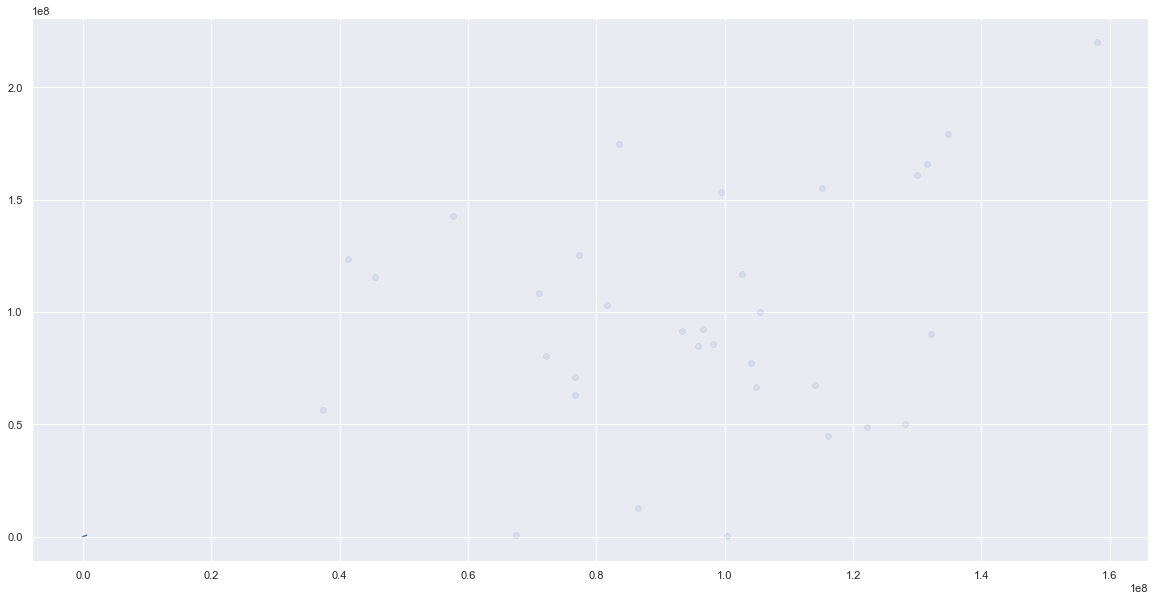

In [468]:
plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))

In [469]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

42843576.181360655

In [470]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [471]:
## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [472]:
## This step applies the scaler to the train set.
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

X_tr = std.transform(X_train.values)

In [473]:
## Apply the scaler to the test set

X_te = std.transform(X_test.values)

In [474]:
## Note that even though we put a Pandas Dataframe into the scalar, what comes out is a numpy array
## In general, sklearn works on numpy.  It will accept pandas objects by trying to coerce them to numpy arrays
## But it will not usually output pandas objects

type(X_train), type(X_tr)

(pandas.core.frame.DataFrame, numpy.ndarray)

(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 85.]),
 array([-2.66145324, -2.35773446, -2.05401567, -1.75029689, -1.44657811,
        -1.14285933, -0.83914055, -0.53542177, -0.23170299,  0.07201579,
         0.37573457]),
 <BarContainer object of 10 artists>)

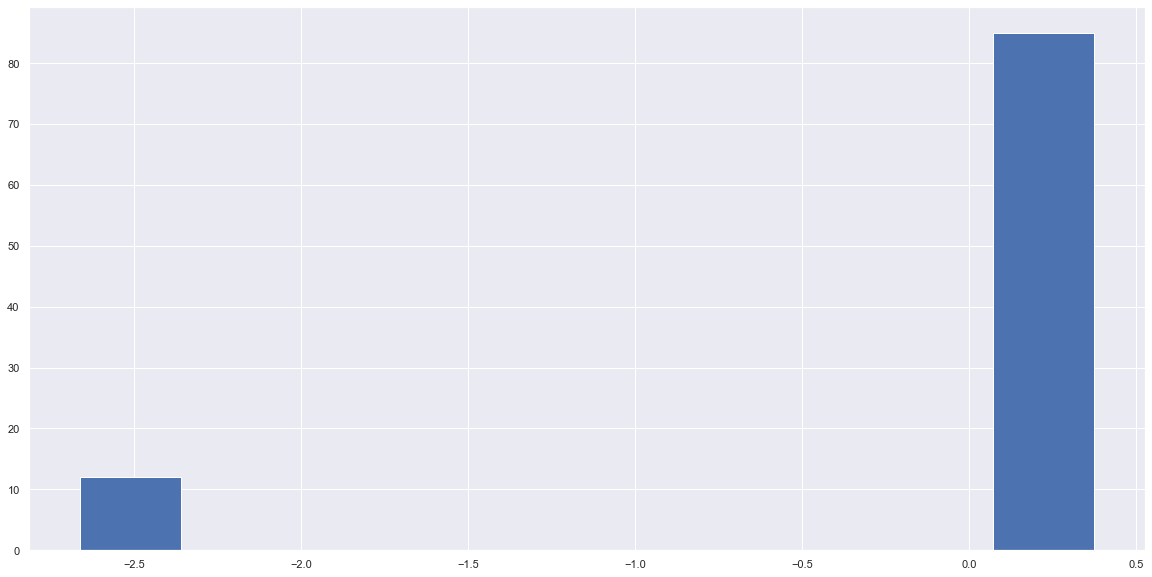

In [475]:
## Here we can plot histograms of the transformed variables
## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)

plt.hist(X_tr[:,3])

In [476]:
## Fit a LASSO model on the standardized data

lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_tr,y_train)

Lasso(alpha=10000)

In [477]:
## Note that now we can meaningful compare the importance of
## different features, since they're on the same scale

## But it's now difficult to interpret the coefficients
## We would need to translate back to the original feature scales by dividing
## each coefficient by the original column's standard deviation

list(zip(X_train.columns, lasso_model.coef_))

[('foreign_market_count_clean', 4177076.575347328),
 ('budget_clean', 22472399.835934628),
 ('dummy_for_action', -8304927.853393273),
 ('dummy_for_adventure', 13416438.31402906),
 ('dummy_for_animation', -1051971.799609717),
 ('dummy_for_comedy', -2422936.787267538),
 ('dummy_for_crime', -889645.6437991207),
 ('dummy_for_drama', 8247751.635853863),
 ('dummy_for_family', -16582210.721804693),
 ('dummy_for_fantasy', -6902492.0070397025),
 ('dummy_for_mystery', 9069940.619389204),
 ('dummy_for_thriller', -2390956.107617102),
 ('dummy_for_disney', 9731998.873972071),
 ('dummy_for_rating_G', -13920204.257121798),
 ('dummy_for_rating_PG', -18636529.016421627),
 ('dummy_for_rating_PG13', -25897265.41875456)]

In [478]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,:].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,:].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

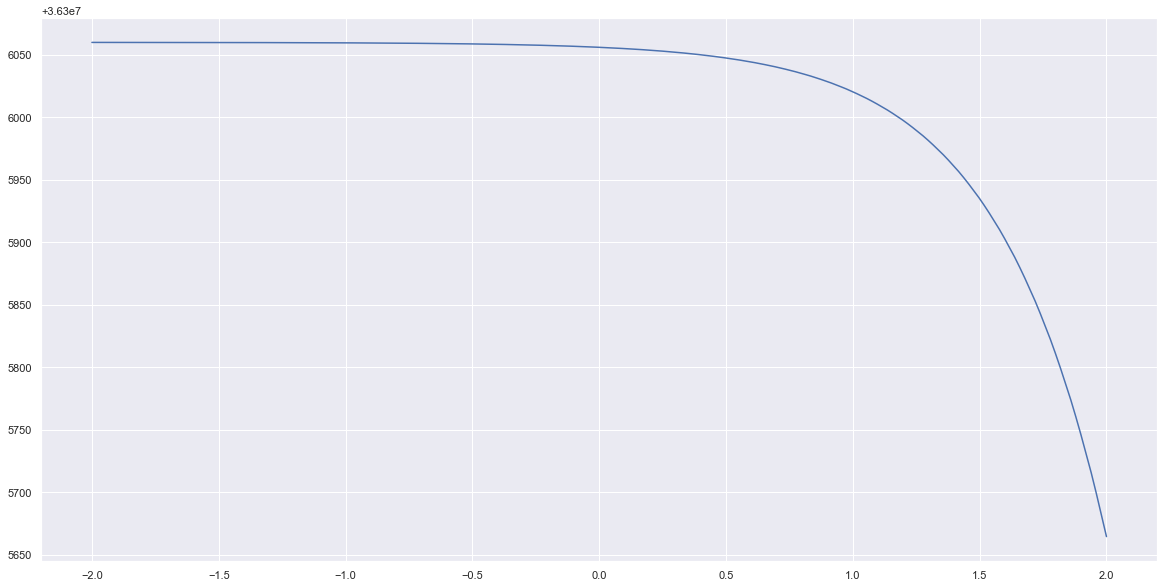

In [479]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [480]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

36305664.67924392

In [481]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

100.0

In [482]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [483]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [484]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [485]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

100.0

In [486]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))


[('foreign_market_count_clean', 4206013.478951329),
 ('budget_clean', 22478519.334408943),
 ('dummy_for_action', -8368245.645508034),
 ('dummy_for_adventure', 13497052.925129),
 ('dummy_for_animation', -1036758.7515258006),
 ('dummy_for_comedy', -2457841.8661280256),
 ('dummy_for_crime', -896477.569183494),
 ('dummy_for_drama', 8248458.587758587),
 ('dummy_for_family', -16635145.078648807),
 ('dummy_for_fantasy', -6910586.442758431),
 ('dummy_for_mystery', 9098882.17230965),
 ('dummy_for_thriller', -2405282.7892837287),
 ('dummy_for_disney', 9757226.790942274),
 ('dummy_for_rating_G', -13989565.101446822),
 ('dummy_for_rating_PG', -18788544.101936128),
 ('dummy_for_rating_PG13', -26065453.00115962)]

In [487]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [488]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

44796467.40557401

In [489]:
r2_score(y_test, test_set_pred)

-0.23050170202131026